SchNet on IPU
=============
> *Note: PyTorch Geometric support with PopTorch SDK 2.6 is currently experimental.*
> *Please direct any questions or feedback to support@graphcore.ai*


This notebook demonstrates training a [SchNet graph neural network](https://arxiv.org/abs/1712.06113) with PyTorch Geometric on the Graphcore IPU.  We will use the QM9 dataset from the [MoleculeNet: A Benchmark for Molecular
    Machine Learning](https://arxiv.org/abs/1703.00564) paper and train the SchNet model to predict the HOMO-LUMO energy gap.

This notebook assumes some familiarity with PopTorch as well as PyTorch Geometric (PyG).  For additional resources please consult:

* [PopTorch Documentation](https://docs.graphcore.ai/projects/poptorch-user-guide/en/latest/index.html)
* [PopTorch Examples and Tutorials](https://docs.graphcore.ai/en/latest/examples.html#pytorch)
* [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/)

Requirements:

* A Poplar SDK environment enabled (see the Getting Started guide for your IPU system
* Python packages installed with `pip install -r requirements.txt`


In [ ]:
%pip install -r requirements.txt

In [1]:
%matplotlib inline

import torch
import poptorch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import py3Dmol

from periodictable import elements
from torch_geometric.datasets import QM9
from torch_geometric.data import Batch, Data
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import RadiusGraph, Distance, Compose, BaseTransform
from tqdm import tqdm

### QM9 Dataset

PyG provides a convenient dataset class that manages downloading the QM9 dataset to local storage. The QM9 dataset contains 130831 molecules with a number of different physical properties that we can train the SchNet model to predict.  For SchNet, a molecule with $n$ atoms is described by:

* Nuclear charges $Z= (Z_1, Z_2, ..., Z_n)$, stored as a vector of integers of length `num_atoms`
* Atomic positions $\mathbf{r} = (\mathbf{r}_1, \mathbf{r}_2, \ldots, \mathbf{r}_n)$, stored as a tensor of real numbers of size `[num_atoms, 3]`

We consider each molecule as an undirected graph where:
* the atoms are the nodes or vertices of the graph.
* the edges are inferred from the atomic positions by connecting atoms that are within a given cutoff radius to each other.

In [2]:
root = "./data"
dataset = QM9(root)

We can call `len` to see how many molecules are in the dataset

In [3]:
len(dataset)

130831

We can inspect each molecule which is represented as an instance of a [torch_geometric.data.Data](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data) object.  The properties we are interested in for training our SchNet model are:
* `z` contains the atomic number for each atom in the molecule.
* `pos` contains the 3d structure of the molecule.
* `y` contains the 19 regression targets.  The HOMO-LUMO gap is stored in the 4th column so can be accessed by slicing this tensor using `y[:,4]`

Next we display the first example molecule from the QM9 dataset as a `Data` object, the atomic number tensor, the positions tensor, and slice the regression targets to get the HOMO-LUMO gap for this example.

In [4]:
datum = dataset[0]
datum, datum.z, datum.pos, datum.y[:, 4]

(Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5]),
 tensor([6, 1, 1, 1, 1]),
 tensor([[-1.2700e-02,  1.0858e+00,  8.0000e-03],
         [ 2.2000e-03, -6.0000e-03,  2.0000e-03],
         [ 1.0117e+00,  1.4638e+00,  3.0000e-04],
         [-5.4080e-01,  1.4475e+00, -8.7660e-01],
         [-5.2380e-01,  1.4379e+00,  9.0640e-01]]),
 tensor([13.7363]))

We can use the [py3Dmol](https://github.com/3dmol/3Dmol.js/tree/master/py3Dmol) package to visualise the molecule to get a better idea of the structure.  To do this we need to provide the simple `xyz` format to the `py3Dmol.view` function.

In [5]:
num_atoms = int(datum.z.numel())
xyz = f"{num_atoms}\n\n"

for i in range(num_atoms):
    sym = elements[datum.z[i].item()].symbol
    r = datum.pos[i, :].tolist()
    line = [sym] + [f"{i: 0.08f}" for i in r]
    line = "\t".join(line)
    xyz += f"{line}\n"

py3Dmol.view(data=xyz, style={'stick': {}})


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

We can collect some statistics by iterating over the entire dataset and investigate the distribution of the number of atoms in each molecule and the HOMO-LUMO gap energy

In [6]:
num_mols = len(dataset)
num_atoms = torch.zeros(num_mols)
gap = torch.zeros(num_mols)

for i, mol in enumerate(dataset):
    num_atoms[i] = mol.z.numel()
    gap[i] = mol.y[:, 4]


The following histogram shows how the number of atoms varies across the QM9 dataset.

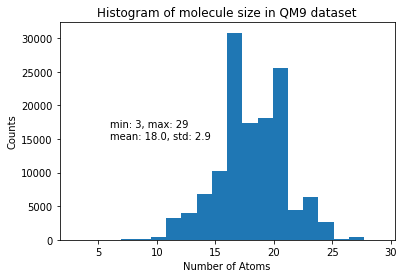

In [7]:
min_num_atoms = int(num_atoms.min())
max_num_atoms = int(num_atoms.max())
mean_num_atoms = float(num_atoms.mean())
std_num_atoms = float(num_atoms.std())

plt.hist(num_atoms.numpy(), 20)
plt.xlabel("Number of Atoms")
plt.ylabel("Counts")
plt.title("Histogram of molecule size in QM9 dataset")
plt.text(
    6, 15000,
    f'min: {min_num_atoms}, max: {max_num_atoms}\nmean: {mean_num_atoms:.1f}, std: {std_num_atoms:.1f}'
)
plt.show()

The following histogram shows how the HOMO-LUMO gap varies across the QM9 dataset.

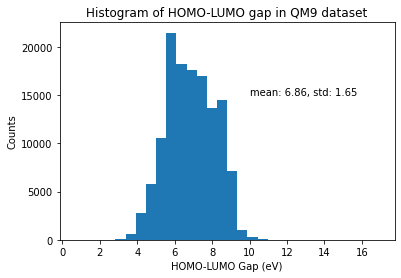

In [8]:
mean = float(gap.mean())
std = float(gap.var())

plt.hist(gap.numpy(), 30)
plt.xlabel("HOMO-LUMO Gap (eV)")
plt.ylabel("Counts")
plt.title("Histogram of HOMO-LUMO gap in QM9 dataset")
plt.text(10, 15000, f'mean: {mean:.2f}, std: {std:.2f}')
plt.show()

## Data Loading and Batching

PyG provides a specialized version of the native PyTorch [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html):

* [torch_geometric.data.DataLoader](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.DataLoader)


The PyG dataloader supports a form of mini-batching which is [decribed here](https://pytorch-geometric.readthedocs.io/en/latest/notes/batching.html).  Effectively each mini-batch is a concatenation of multiple graphs (molecules in QM9).  Another way to understand this is that each mini-batch is one large graph comprised of multiple disconnected sub-graphs.  The PyG dataloader will generate a `batch` vector that assigns each feature in the mini-batch into a distinct subgraph.  This is useful for message passing networks (such as SchNet) and pooling layers to produce a distinct regression prediction for each molecule. Refer to the following tutorials for additional background:

* [Creating message passing networks](https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html)
* [Global Pooling Layers](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html?highlight=pooling#global-pooling-layers)

This mini-batching approach needs to be adapted for the IPU since the tensor sizes will vary from batch to batch.  This can be observed in the following cell where tensors such as `batch`, `z`, and `pos` all have different sizes between the first two batches of the QM9 dataset. 

In [9]:
loader = DataLoader(dataset, batch_size=4)

it = iter(loader)
next(it), next(it)

(DataBatch(x=[16, 11], edge_index=[2, 24], edge_attr=[24, 4], y=[4, 19], pos=[16, 3], idx=[4], name=[4], z=[16], batch=[16], ptr=[5]),
 DataBatch(x=[21, 11], edge_index=[2, 34], edge_attr=[34, 4], y=[4, 19], pos=[21, 3], idx=[4], name=[4], z=[21], batch=[21], ptr=[5]))

### SchNet Model Architecture

![SchNet Architecture](./static_resources/schnet_arch.png "SchNet Architecture")

The diagram above demonstrates the overall architecture of the SchNet model.  The main inputs to the model are:
* $(Z_1, Z_2, \ldots, Z_n)$ : A vector of atomic numbers which are used as input to the atom-wise embedding layer.
* $(\mathbf{r}_1, \mathbf{r}_2, \ldots, \mathbf{r}_n)$: A `[n, 3]` tensor of atomic positions.

The graph is defined by considering each atom as a node and the edges are defined by:
* placing a sphere of radius $r_\textrm{cut}$ centered on each atom.
* connecting neighbouring atoms that fall within the cutoff sphere with an undirected edge.

The rationale for using this cutoff sphere is to bound the maximum number of atoms that are connected to each other so that the computational cost grows linearly with the number of atoms in the system.

In practice we can use the `radius_graph` [transform](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.RadiusGraph) from PyTorch Geometric to calculate the edges from the input `pos` tensor.  All this said, for the QM9 dataset we select a large enough $r_\textrm{cut}$ to result in a fully-connected graph since all of the molecules are relatively small.  



### IPU implementation of SchNet

The following implementation is adapted from the PyTorch Geometric implementation of
SchNet. The main differences are: 

* the interaction graph must be pre-computed as part of the dataset pre-processing.
* all inputs of the forward method are padded to meet the static tensor shape requirements of the IPU.
* dataset standardization is not handled by the model. Instead this is expected to be handled in the dataset pre-processing when necessary.

Padding atoms are defined as having atomic charge of zero and are 
non-interacting. Padding edges are defined as having a length equal to the
cutoff to ensure they are excluded from the radial basis expansion.

In [10]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.init import xavier_uniform_, zeros_

from torch_geometric.nn.models.schnet import GaussianSmearing, \
    InteractionBlock, ShiftedSoftplus
from torch_scatter.scatter import scatter_add
from poptorch import identity_loss


class SchNet(nn.Module):
    def __init__(self,
                 num_features=128,
                 num_interactions=2,
                 num_gaussians=50,
                 cutoff=6.0,
                 batch_size=None):
        """
        :param num_features (int): The number of hidden features used by both
            the atomic embedding and the convolutional filters (default: 128).
        :param num_interactions (int): The number of interaction blocks
            (default: 2).
        :param num_gaussians (int): The number of gaussians used in the radial
            basis expansion (default: 50).
        :param cutoff (float): Cutoff distance for interatomic interactions
            which must match the one used to build the radius graphs
            (default: 6.0).
        :param batch_size (int, optional): The number of molecules in the batch.
            This can be inferred from the batch input when not supplied.
        """
        super().__init__()
        self.num_features = num_features
        self.num_interactions = num_interactions
        self.num_gaussians = num_gaussians
        self.cutoff = cutoff
        self.batch_size = batch_size

        self.atom_embedding = nn.Embedding(100,
                                           self.num_features,
                                           padding_idx=0)
        self.basis_expansion = GaussianSmearing(0.0, self.cutoff,
                                                self.num_gaussians)

        self.interactions = nn.ModuleList()

        for _ in range(self.num_interactions):
            block = InteractionBlock(self.num_features, self.num_gaussians,
                                     self.num_features, self.cutoff)
            self.interactions.append(block)

        self.lin1 = nn.Linear(self.num_features, self.num_features // 2)
        self.act = ShiftedSoftplus()
        self.lin2 = nn.Linear(self.num_features // 2, 1)

        self.reset_parameters()

    def reset_parameters(self):
        """
        Initialize learnable parameters used in training the SchNet model.
        """
        self.atom_embedding.reset_parameters()

        for interaction in self.interactions:
            interaction.reset_parameters()

        xavier_uniform_(self.lin1.weight)
        zeros_(self.lin1.bias)
        xavier_uniform_(self.lin2.weight)
        zeros_(self.lin2.bias)

    def forward(self, z, edge_weight, edge_index, batch, target=None):
        """
        Forward pass of the SchNet model

        :param z: Tensor containing the atomic numbers for each atom in the 
            batch. Vector of integers with size [num_atoms].
        :param edge_weight: Tensor containing the interatomic distances for each
            interacting pair of atoms in the batch. Vector with size [num_edges]
        :param edge_index: Tensor containing the indices defining the 
            interacting pairs of atoms in the batch. Matrix of integers with 
            size [2, num_edges]
        :param batch: Tensor assigning each atom within a batch to a molecule.
            This is used to perform per-molecule aggregation to calculate the
            predicted energy. Vector of integers with size [num_atoms]
        :param target (optional): Tensor containing the target to
            use for evaluating the mean-squared-error loss when training.
        """
        # Collapse any leading batching dimensions
        z = z.view(-1)
        edge_weight = edge_weight.view(-1)
        edge_index = edge_index.view(2, -1)

        h = self.atom_embedding(z)
        edge_attr = self.basis_expansion(edge_weight)

        for interaction in self.interactions:
            h = h + interaction(h, edge_index, edge_weight, edge_attr)

        h = self.lin1(h)
        h = self.act(h)
        h = self.lin2(h)

        # zero out
        mask = (z == 0).view(-1, 1)
        h = h.masked_fill(mask.expand_as(h), 0.)

        batch = batch.view(-1)
        out = scatter_add(h, batch, dim=0, dim_size=self.batch_size).view(-1)

        if not self.training:
            return out

        target = target.view(-1)
        loss = self.loss(out, target)
        return out, loss

    @staticmethod
    def loss(input, target):
        """
        Calculates the mean squared error

        This loss assumes that zeros are used as padding on the target so that
        the count can be derived from the number of non-zero elements.
        """
        loss = F.mse_loss(input, target, reduction="sum")
        N = (target != 0.0).to(loss.dtype).sum()
        loss = loss / N
        return identity_loss(loss, reduction="none")


As a basic sanity check we can compile the SchNet model with PopTorch and check that we get the same prediction as running the model on the host CPU.

Prepare a mock batch consisting of a single graph. The transforms generate the implicit edges between all pairs of atoms in the molecule.

In [11]:
cutoff = 6.0
transforms = Compose([RadiusGraph(r=cutoff), Distance(norm=False, cat=False)])
data = transforms(dataset[0])
batch = Batch.from_data_list([data])
batch

DataBatch(x=[5, 11], edge_index=[2, 20], y=[1, 19], pos=[5, 3], idx=[1], name=[1], z=[5], edge_attr=[20, 1], batch=[5], ptr=[2])

Evaluate the network on the host with randomly initialised weights using a fixed random seed

In [12]:
torch.manual_seed(0)
model = SchNet(cutoff=cutoff)
model.eval()
cpu = model(batch.z, batch.edge_attr, batch.edge_index, batch.batch,
            batch.y[:, 4])
cpu

tensor([2.7464], grad_fn=<ViewBackward0>)

Now evaluate the network on the IPU

In [13]:
pop_model = poptorch.inferenceModel(model)
ipu = pop_model(batch.z, batch.edge_attr, batch.edge_index, batch.batch,
                batch.y[:, 4])
ipu


Graph compilation:   0%|          | 0/100 [00:00<?]2022-07-21T19:49:51.483220Z popart:devicex 75439.75439 W: The `debug.retainDebugInformation` engine option was implicitly set to `true`. The default will change to `false` in a future release. Set it to `true` explicitly if you want to query debug information (for example, by calling `Session::getReport`).
2022-07-21T19:49:51.634930Z popart:devicex 75439.75439 W: The `debug.retainDebugInformation` engine option was implicitly set to `true`. The default will change to `false` in a future release. Set it to `true` explicitly if you want to query debug information (for example, by calling `Session::getReport`).
Graph compilation: 100%|██████████| 100/100 [00:07<00:00]


tensor([2.7464])

The predictions must be the same

In [14]:
torch.allclose(cpu, ipu)

True

### Padding
The easiest way to get up and running on the IPU with the QM9 dataset is just to apply padding to the input tensors. This results in every example in the dataset being expanded up to the size of the largest molecule.  This expansion comes at the cost of additional padding nodes and edges.

Next we define the `PadMolecule` [transform](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html) which modifies each `Data` instance in the dataset to have `max_num_atoms` nodes `max_num_atoms * (max_num_atoms - 1)` edges.

In [15]:
class PadMolecule(BaseTransform):
    """
    Data transform that applies padding to enforce consistent tensor shapes.

    Padding atoms are defined as have atomic charge of zero. Padding edges are
    defined as having a length equal to the cutoff used in the Schnet network.
    """
    def __init__(self, max_num_atoms: int, cutoff: float):
        """
        :param max_num_atoms (int): The maximum number of atoms to pad
            the atom numbers up to.
        :param cutoff (float): The cutoff in Angstroms used in the SchNet model.
        """
        super().__init__()
        self.max_num_atoms = max_num_atoms
        self.cutoff = cutoff

        # Assume fully connected graph between all atoms
        self.max_num_edges = max_num_atoms * (max_num_atoms - 1)

    def validate(self, data):
        """
        Validates that the input molecule does not exceed the constraints that:

          * the number of atoms must be <= max_num_atoms
          * the number of edges must be <= max_num_edges

        :returns: Tuple containing the number atoms and the number of edges
        """
        num_atoms = data.z.numel()
        num_edges = data.edge_index.shape[1]

        assert num_atoms <= self.max_num_atoms, \
            f"Too many atoms. Molecule has {num_atoms} atoms "\
            f"and max_num_atoms is {self.max_num_atoms}."

        assert num_edges <= self.max_num_edges, \
            f"Too many edges. Molecule has {num_edges} edges defined "\
            f"and max_num_edges is {self.max_num_edges}."

        return num_atoms, num_edges

    def __call__(self, data):
        num_atoms, num_edges = self.validate(data)

        num_fake_atoms = self.max_num_atoms - num_atoms
        data.z = F.pad(data.z, (0, num_fake_atoms))
        data.num_nodes = self.max_num_atoms

        # Fake edges are self-loops on the first atom.
        num_fake_edges = self.max_num_edges - num_edges
        data.edge_index = F.pad(data.edge_index, (0, num_fake_edges, 0, 0),
                                value=0)
        data.edge_attr = F.pad(data.edge_attr.squeeze(1), (0, num_fake_edges),
                               value=self.cutoff)
        return data


Next we define another data transform for extracting a selected regression target from the QM9 dataset and extracting only the relevant input features for training SchNet.

In [16]:
class PrepareData(BaseTransform):
    """
    Data transform for preparing each data instance by:
        * extracting a given target label from the PyG QM9 dataset
        * slicing the data objet to only contain the provided properties.

    The QM9 dataset consists of a total of 19 regression targets. This transform
    indexes the regression targets stored in data.y to only include the selected
    target.

    Expected input:
        data.y is a vector with shape [1, 19]

    Transformed output:
        data.y is as scalar with shape torch.Size([])
    """
    def __init__(self, target, keys):
        self.target = target
        self.keys = keys

    def validate(self, data):
        assert hasattr(data, "y") \
          and isinstance(data.y, torch.Tensor) \
          and data.y.shape == (1, 19),\
          "Invalid data input. Expected data.y == Tensor with shape [1, 19]"

    def __call__(self, data):
        self.validate(data)
        data.y = data.y[0, self.target]

        values = [getattr(data, k) for k in self.keys]
        kwargs = dict([*zip(self.keys, values)])
        return Data(**kwargs)

We now add a helper function that creates the full data pre-processing pipeline

In [17]:
def create_transform(cutoff: float, max_num_atoms):
    """
    Creates a sequence of transforms defining a data pre-processing pipeline

    :param cutoff (float): Cutoff distance for interatomic interactions in
        Angstroms (default: 6.0).
    :param max_num_atoms (int): The maximum number of atoms used by the
        PadMolecule transform (default: 32).

    :returns: A composite transform
    """
    # The HOMO-LUMO gap is target 4 in QM9
    target = 4
    keys = ("z", "edge_attr", "edge_index", "y", "num_nodes")

    return Compose([
        RadiusGraph(cutoff),
        Distance(norm=False, cat=False),
        PadMolecule(cutoff=cutoff, max_num_atoms=max_num_atoms),
        PrepareData(target=target, keys=keys)
    ])

We can explore how the pipeline converts an input molecule into one that is padded up to the maximum graph size in the dataset.  An experiment to try is to change the value of `i` to explore the data.

In [18]:
transform = create_transform(cutoff=cutoff, max_num_atoms=int(num_atoms.max()))

i = 1
dataset[i], transform(dataset[i])

(Data(x=[4, 11], edge_index=[2, 6], edge_attr=[6, 4], y=[1, 19], pos=[4, 3], idx=[1], name='gdb_2', z=[4]),
 Data(edge_index=[2, 812], edge_attr=[812], y=9.249149322509766, z=[29], num_nodes=29))

The next sanity check is to verify that the padding hasn't introduced any artificial artifacts in the resulting prediction.  Once again we prepare a mock batch consisting of a single graph but apply the transform we made earlier by calling `create_transform`

In [19]:
data = transform(dataset[0])
batch = Batch.from_data_list([data])
batch

DataBatch(edge_index=[2, 812], edge_attr=[812], y=[1], z=[29], num_nodes=29, batch=[29], ptr=[2])

Evaluate the network on the host with randomly initialised weights using a fixed random seed and the padded batch

In [20]:
torch.manual_seed(0)
model = SchNet(cutoff=cutoff)
model.eval()
padded_cpu = model(batch.z, batch.edge_attr, batch.edge_index, batch.batch,
                   batch.y)
padded_cpu

tensor([2.7464], grad_fn=<ViewBackward0>)

The result should be the same as the one we calculated earlier without any padding

In [21]:
torch.allclose(cpu, padded_cpu)

True

Now evaluate the same test using the IPU

In [22]:
pop_model = poptorch.inferenceModel(model)
padded_ipu = pop_model(batch.z, batch.edge_attr, batch.edge_index, batch.batch,
                       batch.y)
padded_ipu

Graph compilation:   0%|          | 0/100 [00:00<?]2022-07-21T19:50:01.432319Z popart:devicex 75439.75439 W: The `debug.retainDebugInformation` engine option was implicitly set to `true`. The default will change to `false` in a future release. Set it to `true` explicitly if you want to query debug information (for example, by calling `Session::getReport`).
2022-07-21T19:50:01.587935Z popart:devicex 75439.75439 W: The `debug.retainDebugInformation` engine option was implicitly set to `true`. The default will change to `false` in a future release. Set it to `true` explicitly if you want to query debug information (for example, by calling `Session::getReport`).
Graph compilation: 100%|██████████| 100/100 [00:08<00:00]


tensor([2.7464])

The predictions must be the same as calculated earlier without any paddding

In [23]:
torch.allclose(ipu, padded_ipu)

True

### Efficient data loading for the IPU

PopTorch provides a custom data loader implementation that can be used for efficient data batching and transfers between the host and IPU device.  Please refer to the following resources for additional background:
* PopTorch documentation [Efficient data batching](https://docs.graphcore.ai/projects/poptorch-user-guide/en/latest/batching.html#efficient-data-batching)
* PopTorch tutorial: [Efficient data loading](https://github.com/graphcore/tutorials/tree/sdk-release-2.5/tutorials/pytorch/tut2_efficient_data_loading)

Below we define a custom collater that leverages the PyG graph batching for the IPU.  This collator ensures that advanced batching scenarios such as data-parallel training, multiple device iterations, and gradient accumulation are handled correctly. These concepts are all covered in much greater detail in the resources above.

In [24]:
class CombinedBatchingCollator:
    """ Collator object that manages the combined batch size defined as:

        combined_batch_size = mini_batch_size * device_iterations
                             * replication_factor * gradient_accumulation

    This is intended to be used in combination with the poptorch.DataLoader
    """
    def __init__(self, mini_batch_size, keys):
        """
        :param mini_batch_size (int): mini batch size used by the SchNet model
        :param keys: Keys to include from the batch in the
            output tuple specified as either a list or tuple of strings. The
            ordering of the keys is preserved in the tuple.
        """
        super().__init__()
        self.mini_batch_size = mini_batch_size
        self.keys = keys

    def batch_to_tuple(self, data_list):
        batch = Batch.from_data_list(data_list)
        return tuple(getattr(batch, k) for k in self.keys)

    def __call__(self, batch):
        num_items = len(batch)
        assert num_items % self.mini_batch_size == 0, "Invalid batch size. " \
            f"Got {num_items} graphs and mini_batch_size={self.mini_batch_size}."

        num_mini_batches = num_items // self.mini_batch_size
        batches = [None] * num_mini_batches
        start = 0
        stride = self.mini_batch_size

        for i in range(num_mini_batches):
            slices = batch[start:start + stride]
            batches[i] = self.batch_to_tuple(slices)
            start += stride

        num_outputs = len(batches[0])
        outputs = [None] * num_outputs

        for i in range(num_outputs):
            outputs[i] = torch.stack(tuple(item[i] for item in batches))

        return tuple(outputs)

Next we define a helper function that creates an instance of `poptorch.DataLoader` that uses the collator defined above.

In [25]:
def create_dataloader(dataset,
                      ipu_opts,
                      batch_size=1,
                      shuffle=False,
                      num_workers=0):
    """
    Creates a data loader for graph datasets
    Applies the mini-batching method of concatenating multiple graphs into a 
    single graph with multiple disconnected subgraphs. See:
    https://pytorch-geometric.readthedocs.io/en/2.0.2/notes/batching.html
    """
    if ipu_opts is None:
        ipu_opts = poptorch.Options()

    keys = ("z", "edge_attr", "edge_index", "batch", "y")
    collater = CombinedBatchingCollator(batch_size, keys)

    return poptorch.DataLoader(ipu_opts,
                               dataset=dataset,
                               batch_size=batch_size,
                               shuffle=shuffle,
                               num_workers=num_workers,
                               collate_fn=collater)

### Putting everything together to train SchNet

We can now train SchNet on the IPU using all of the concepts introduced earlier.  To start with we shuffle and split the dataset into testing, validation, and training splits.

In [26]:
num_test = 10000
num_val = 10000
torch.manual_seed(0)
dataset.transform = create_transform(cutoff, int(num_atoms.max()))
dataset = dataset.shuffle()
test_dataset = dataset[:num_test]
val_dataset = dataset[num_test:num_test + num_val]
train_dataset = dataset[num_test + num_val:]

print(f"Number of test molecules: {len(test_dataset)}\n"
      f"Number of validation molecules: {len(val_dataset)}\n"
      f"Number of training molecules: {len(train_dataset)}")


Number of test molecules: 10000
Number of validation molecules: 10000
Number of training molecules: 110831


Setup the hyperparameters for training the network.  These can be changed to explore the different trade-offs they offer in terms of training accuracy and performance throughput.

In [27]:
batch_size = 12
replication_factor = 8
device_iterations = 6
gradient_accumulation = 2
num_dataloader_workers = 16
learning_rate = 1e-3
num_epochs = 20

Create the `poptorch.Options` object with the right parameters setup

In [28]:
options = poptorch.Options()
options.outputMode(poptorch.OutputMode.All)
options.deviceIterations(device_iterations)
options.replicationFactor(replication_factor)
options.Training.gradientAccumulation(gradient_accumulation);

Create the SchNet model and train it using the selected hyperparameters.

In [29]:
train_loader = create_dataloader(train_dataset,
                                 options,
                                 batch_size,
                                 shuffle=True,
                                 num_workers=num_dataloader_workers)
model = SchNet(cutoff=cutoff, batch_size=batch_size)
model.train()
optimizer = poptorch.optim.AdamW(model.parameters(), lr=learning_rate)
model = poptorch.trainingModel(model, options, optimizer)

Train the model and log the mean loss from each batch.

In [30]:
train_losses = torch.empty(num_epochs, len(train_loader))

for epoch in range(num_epochs):
    bar = tqdm(train_loader)
    for i, data in enumerate(bar):
        _, mini_batch_loss = model(*data)
        train_losses[epoch, i] = mini_batch_loss.mean()
        bar.set_description(
            f"Epoch {epoch} training loss: {train_losses[epoch, i].item():0.6f}")

  0%|          | 0/96 [00:00<?, ?it/s]2022-07-21T19:50:17.993258Z popart:devicex 75439.75439 W: The `debug.retainDebugInformation` engine option was implicitly set to `true`. The default will change to `false` in a future release. Set it to `true` explicitly if you want to query debug information (for example, by calling `Session::getReport`).
2022-07-21T19:50:18.858363Z popart:devicex 75439.75439 W: The `debug.retainDebugInformation` engine option was implicitly set to `true`. The default will change to `false` in a future release. Set it to `true` explicitly if you want to query debug information (for example, by calling `Session::getReport`).
Epoch 19 training loss: 0.059838: 100%|██████████| 96/96 [00:04<00:00, 22.59it/s]


Plot the mean of the loss

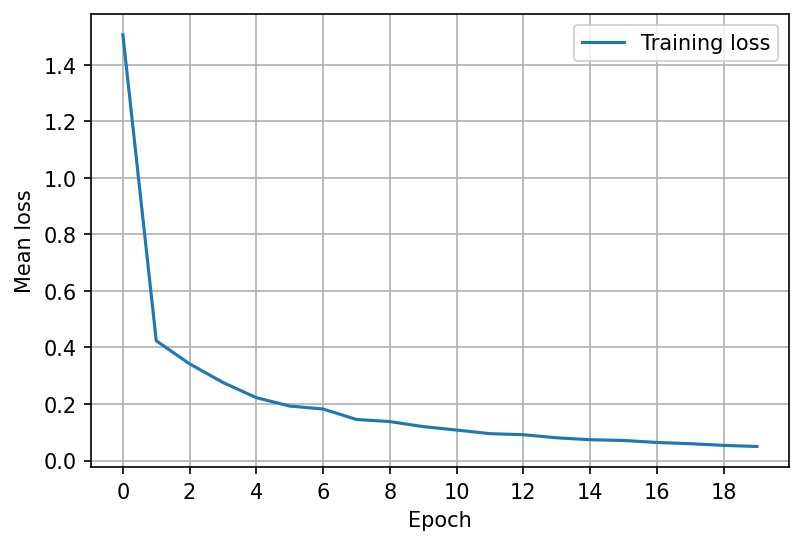

In [31]:
plt.plot(train_losses.mean(dim=1))
plt.xlabel("Epoch")
plt.ylabel("Mean loss")
plt.legend(["Training loss"])
plt.grid(True)
plt.xticks(torch.arange(0, num_epochs, 2))
plt.gcf().set_dpi(150)

### Follow up exercises
* Padding each graph up to the size of the largest molecule is obviously wasteful, can you devise a more efficient strategy?